# 1. Extract Frames from Selected Film

Extract frames and get thumbnail images for checking accuracy

In [1]:
import cv2
from IPython.display import display, Image
from tqdm import tqdm

TIME_INTERVAL = 5.0 # second(s)

VIDEO_PATH = '../../Temp/我们村里的年轻人（续集）.mp4'

Running with OpenCV version 4.7.0
Video name: 我们村里的年轻人（续集）


Extracting frames: 100%|█████████▉| 5365.0/5391.155000000001 [00:12<00:00, 445.22it/s]


1079 frames extracted with the time interval of 5.0 secs.
Last frame example:


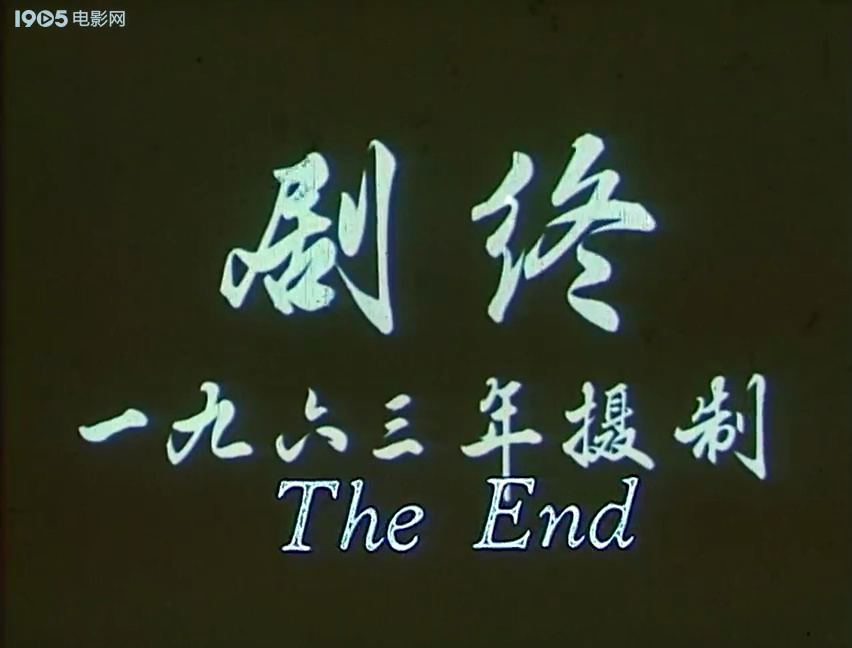

Extracting frames: 5395.0it [00:12, 421.98it/s]                                       


In [2]:
print("Running with OpenCV version " + cv2.__version__)

VIDEO_NAME = VIDEO_PATH.split('/')[-1]
if VIDEO_NAME.endswith('.mp4'):
	VIDEO_NAME = VIDEO_NAME[:-4]
print("Video name: " + VIDEO_NAME)

def extractImages(pathIn, pathOut, export_thumbnails=False, thumbnail_path="./thumbnails/cache/", thumbnail_interval=1, thumbnail_scale=0.25):
	"""
	Parameters
	----------
	export_thumbnails: boolean, whether to export thumbnails
	thumbnail_path: string, path (relative) to save thumbnails
	thumbnail_interval: int, after how many frames to save a thumbnail
	"""
    
	count = 0
	vidcap = cv2.VideoCapture(pathIn)
	success,image = vidcap.read()
	success = True
	total_secs = vidcap.get(cv2.CAP_PROP_FRAME_COUNT) / vidcap.get(cv2.CAP_PROP_FPS)

	p_bar = tqdm(total=total_secs, desc='Extracting frames')
	#p_bar = FloatProgress(min=0, max=total_secs, description='Extracting frames')
	#display(p_bar)

	while success:
		pos = count*TIME_INTERVAL # seconds
		if pos > total_secs:
			break
		
		vidcap.set(cv2.CAP_PROP_POS_MSEC, pos * 1000)
		p_bar.update(TIME_INTERVAL)
		#p_bar.value = pos
		success,image = vidcap.read()
		
		target = pathOut + f"/{VIDEO_NAME}-{count}.jpg"
		#print('sec {} of {} ({})'.format(pos, total_secs, target))
		cv2.imwrite(filename=target, img=image)
		count = count + 1

		if export_thumbnails and count % thumbnail_interval == 0:
			# save a thumbnail with 1/4 size of the original image
			thumb = cv2.resize(image, (0, 0), fx=thumbnail_scale, fy=thumbnail_scale)
			thumbnail_target = thumbnail_path + f"{VIDEO_NAME}-thumb{count}.jpg"
			cv2.imwrite(filename=thumbnail_target, img=thumb)
        
	vidcap.release()
	print(f'\n{count} frames extracted with the time interval of {TIME_INTERVAL} secs.\nLast frame example:')
	display(Image(target)) # show the last frame as an example

extractImages(VIDEO_PATH, "./Temp", export_thumbnails=False, thumbnail_interval=30, thumbnail_scale=0.25)

# 2. Person Identification

Add ONNX format YOLO v7 models to folder "CV/YOLO" to use it in person identification

In [3]:
import numpy as np
import onnxruntime as ort
import glob

w = "YOLO/yolov7-w6.onnx"
cuda = False

In [4]:
providers = ['CoreMLExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
print(providers)
session = ort.InferenceSession(w, providers=providers)

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

names = ['person']
colors = {'person' : [242, 82, 141]}

outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

images = [cv2.imread(file) for file in glob.glob("Temp/*.jpg")]
p_bar = tqdm(total=len(images), desc='Extracting frames')
print(f'Finding people crowds in {len(images)} frames')

number = 0

for img in images:
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

	image = img.copy()
	image, ratio, dwdh = letterbox(image, auto=False)
	image = image.transpose((2, 0, 1))
	image = np.expand_dims(image, 0)
	image = np.ascontiguousarray(image)

	im = image.astype(np.float32)
	im /= 255
	im.shape

	inp = {inname[0]:im}

	outputs = session.run(outname, inp)[0]
	outputs

	ori_images = [img.copy()]

	for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
		image = ori_images[int(batch_id)]
		box = np.array([x0,y0,x1,y1])
		box -= np.array(dwdh*2)
		box /= ratio
		box = box.round().astype(np.int32).tolist()
		cls_id = int(cls_id)
		if cls_id != 0 :
			# only keep person information
			continue
        
		score = round(float(score),3)
		name = names[cls_id]
		color = colors[name]
		name += ' '+str(score)
		cv2.rectangle(image,box[:2],box[2:],color,2)
		cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2) 
        
		number += 1

		if number % 50 == 0:
			image = cv2.resize(image, (0, 0), fx=0.25, fy=0.25)
			cv2.imwrite(f"/{VIDEO_NAME}-detect{p_bar.n}.jpg", image)
    
	p_bar.update(1)

['CPUExecutionProvider']


Extracting frames:   0%|          | 0/1079 [00:00<?, ?it/s]

Finding people crowds in 1079 frames


Extracting frames:   6%|▌         | 65/1079 [00:20<05:24,  3.12it/s]

KeyboardInterrupt: 

# 3. Clear Caches

Clear all cached frame images

In [5]:
# Delete all images in the Temp folder
import os

cleared = 0

for file in os.listdir("./Temp/"):
    if file.endswith(".png") or file.endswith(".jpg"):
            cleared += 1
            os.remove(os.path.join("./Temp", file))
            
print(f"\n{cleared} images cleared.")


1079 images cleared.


# 4. Compress thumbnails (Optional)

Run the cell below to create a ZIP of the thumbnail images and delete the thumbnail images

In [3]:
import shutil

zip_name = ""
try:
    if VIDEO_NAME is None:
        zip_name = "thumbnails"
except NameError:
    zip_name = "thumbnails"
else:
    zip_name = VIDEO_NAME + "-thumbnails"

shutil.make_archive(f"./thumbnails/{zip_name}", 'zip', "./thumbnails/cache/")

cleared = 0

# Delete all images in the thumbnails folder
for file in os.listdir("./thumbnails/cache/"):
    if file.endswith(".jpg"):
            cleared += 1
            os.remove(os.path.join("./thumbnails/cache", file))
            
print(f"\n{cleared} thumbnails compressed.")


35 thumbnails compressed.
